# **MIDAS IIITD - Task 2 Part 1**

#### **Introduction to Method**

For task one, the given dataset has been used to train a CNN network. A brief dataset description is given below:

*   Contains 62 classes.
*   This includes handwritten digits 0-9, alphabets A-Z and lowercase alphabets a-z.

This notebook only contains part one of the task. Other parts are in subsequent noteboks. Further, this notebook is divided into:

1.   Libraries and Other Requirements
2.   Dataset Loading and Preprocessing
3.   Exploratory Data Analysis
4.   Model Building and Training
5.   Training Analysis









# **Libraries Installed**

In [56]:
'''
Libraries required to run the code.
Development was done on Google Colab and hence it is preferable to run on Colab with GPU for faster setup.
'''

import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import os
from collections import Counter
import pickle
import tensorflow as tf
import keras
from  matplotlib import pyplot as plt
from PIL import Image
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.constraints import maxnorm

In [ ]:
'''
Copying Data to Location
'''

!ln -s '/content/drive/MyDrive/MIDAS TASK 2/train' '/content'

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Data Loading and Preprocessing**

In [13]:
# Data stores the Numpy Array while Category is the class.

data = []
category = []

In [14]:
'''
Helper Function to:
1. Load all Images as Numpy Arrays
2. Normalize between 0 and 1 by dividing by 255
3. Check Size to ensure 28*28 images
'''

'''
Preprocessing:
1. Convert 3D image to 1D image to reduce computations.
2. Normalize between 0 and 1.
3. Keep data type as Float32
4. Resize using pillow image library. Resize to (128,128) to improve speed.
'''

img_folder = '/content/train'

def load_data(img_folder):

    for dir1 in tqdm(os.listdir(img_folder)):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            pilload = Image.open(image_path).convert('L')
            pilload = pilload.resize((128,128))
            image= np.array(pilload)
            image = image.astype('float32')
            image /= 255  
            data.append(image)
            category.append(dir1)
            pilload.close()

In [15]:
'''
Loading Dataset using function.
'''

load_data(img_folder)

100%|██████████| 62/62 [00:41<00:00,  1.48it/s]


In [16]:
'''
Create target dictionary
'''

target_dict={k: v for v, k in enumerate(np.unique(category))}
target_val=  [target_dict[category[i]] for i in range(len(category))]

# **EDA**

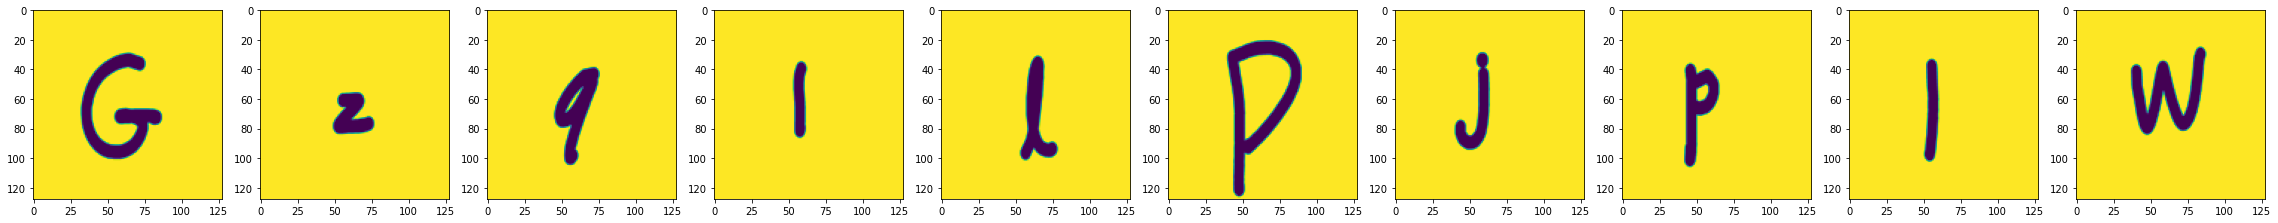

In [17]:
'''
Loading Sample Images
All images are upright and squared. No image rotation and flipping required.
'''

plt.figure(figsize=(40,20))

for i in range(10):
  image = random.choice(data)
  ax=plt.subplot(1,10,i+1)
  plt.imshow(image)

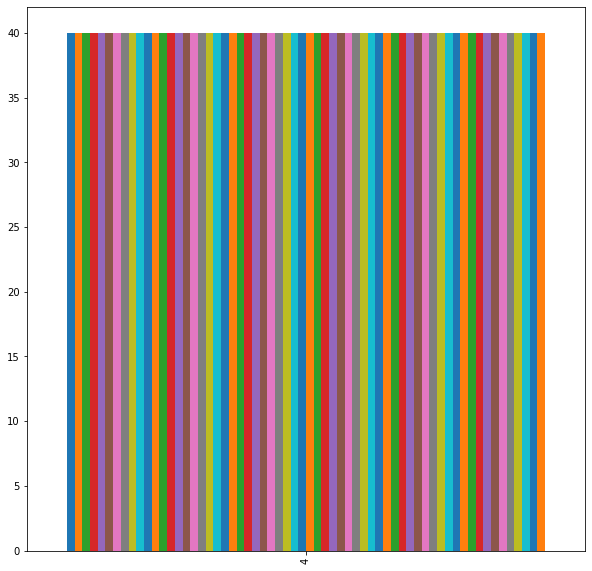

In [18]:
'''
Checking for data imbalance.
We see that there is no data inbalance so we don't need data augmentation techniques.
'''

d = Counter(target_val)
key = d.keys()

df = pd.DataFrame(d,index=key)
df.drop(df.columns[1:], inplace=True)
df.plot(kind='bar', legend = False, figsize=(10, 10), width = 3)

plt.show()

# **Building And Training Model**

#### **Explanation of Model Choice**

1.   Since all categories were equally balance, the use of data augmentation or data generation was not required.
2.   A simple Conv 2D network was defined for the model. 
3.   In case of the convolution filter size, it was reduced for each of the three convolution networks. One of the reason to do this is that it reduces computational costs and weight sharing that ultimately leads to lesser weights for back-propagation.
4.  This also enables the model to better learn features from windows of different sizes.
5. Categorical Cross Entropy is used as the loss function and Adam optimizer is used. Furthermore, ModelCheckpoints are added to :

    *   Save only the best model.
    *   Stop learning if the loss stagnates.
    *   Change learning rate of the model on the fly






In [115]:
'''
The entire data is fed to a Tensorflow Keras based CNN network as described below.
'''

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=12, kernel_size=(5,5), strides=2, activation='relu', 
                              input_shape=(128,128,1)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=18, kernel_size=(3,3) , strides=2, activation='relu'))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=150, activation='relu'))
model.add(keras.layers.Dense(units=62, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 12)        312       
_________________________________________________________________
dropout_16 (Dropout)         (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 18)        1962      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 30, 18)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 29, 29, 24)        1752      
_________________________________________________________________
flatten_10 (Flatten)         (None, 20184)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 150)             

In [116]:
'''
Defining Training Data
'''

X = np.array(data, np.float32).reshape(2480,128,128,1)
Y = tf.keras.utils.to_categorical(target_val, 62)

In [117]:
'''
Adding Callback API's to save best weights and change learning rate on the fly
'''
 
MCP = ModelCheckpoint('/content/drive/MyDrive/MIDAS TASK 2/best.h5', verbose=1, save_best_only=True, monitor='accuracy', mode='max')
ES = EarlyStopping(monitor='accuracy', min_delta=0, verbose=0, restore_best_weights = True, patience=3, mode='max')
RLP = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=0.0001)

In [ ]:
%%time

'''
Training while also calculating time
'''

tf.config.run_functions_eagerly(True)

history = model.fit(X, Y, epochs=50, callbacks=[MCP,ES,RLP]) 

# **Training Analysis**

#### **Basic Training Results**

1.   Accuracy - 94.960%
2.   Time = 53.5 seconds



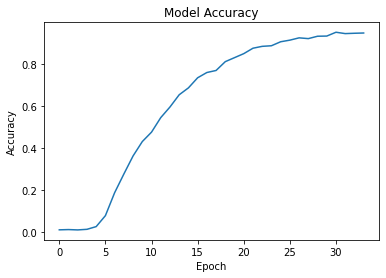

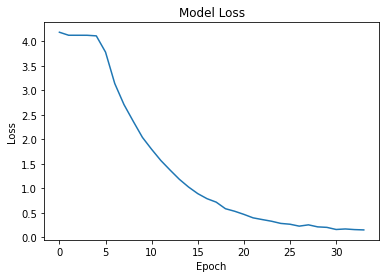

In [119]:
'''
Observing Training
'''

# accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [120]:
'''
Sample Testing
'''

samples_ind = list(range(0, 2481))

for i in range(10):
  ind = random.choice(samples_ind)
  img = X[ind]
  ground_truth = Y[ind]
  print('Ground Truth:', np.argmax(ground_truth))

  prediction = model.predict(X[ind:ind + 1])
  print('Predicted Value:', np.argmax(prediction))

  print()

Ground Truth: 44
Predicted Value: 44

Ground Truth: 30
Predicted Value: 30

Ground Truth: 14
Predicted Value: 14

Ground Truth: 18
Predicted Value: 18

Ground Truth: 26
Predicted Value: 26

Ground Truth: 44


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Predicted Value: 44

Ground Truth: 10
Predicted Value: 10

Ground Truth: 60
Predicted Value: 60

Ground Truth: 53
Predicted Value: 53

Ground Truth: 28
Predicted Value: 28

